<img src="data_viz_mind_the_gap.jpg" alt="MIND THE GENDER GAP" width="50%">

### 2011 UK Census: An Analysis of Demographics, Work, and Gender Disparity
This notebook explores the 2011 UK Census microdata to uncover key demographic and economic patterns across England and Wales. The analysis begins with data loading and cleaning, moves into a broad exploratory data analysis (EDA), and then focuses on two key areas:

    - Geospatial Analysis: Mapping the gender-based disparities in average work hours.

    - Predictive Modeling: Using an Oaxaca-Blinder decomposition to understand the factors contributing to the gender-hours gap.

In [7]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import re
import warnings

# --- Visualization Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import plotly.express as px
import matplotlib.ticker as mtick
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable

# --- Modeling Libraries ---
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import build_design_matrices

# --- Notebook Settings ---
warnings.filterwarnings('ignore')
sns.set_theme(style="white")
plt.rcParams['figure.figsize'] = (10, 6)
FEMALE_COLOR = '#ffb3c6'
MALE_COLOR = '#a0c4ff'

In [8]:
# --- Load Data ---
df = pd.read_csv("data/2011 Census Microdata Teaching File.csv", skiprows=1)
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# --- Define All Mappings ---
region_map = {
    "E12000001": "North East", "E12000002": "North West",
    "E12000003": "Yorkshire", "E12000004": "East Midlands",
    "E12000005": "West Midlands", "E12000006": "East of England",
    "E12000007": "London", "E12000008": "South East",
    "E12000009": "South West", "W92000004": "Wales"
}
residence_map = {"C": "Communal", "H": "Household"}
family_map = {
    1: "Not in family", 2: "Married/Partnered", 3: "Cohabiting",
    4: "Lone parent (male)", 5: "Lone parent (female)", 6: "Other", 0: "Not applicable"
}
sex_map = { 1: "Male", 2: "Female", 0: np.nan }
age_map = {
    1: "0-15", 2: "16-24", 3: "25-34", 4: "35-44",
    5: "45-54", 6: "55-64", 7: "65-74", 8: "75+",
    0: "Not applicable"
}
marital_map = {
    1: "Single", 2: "Married", 3: "Separated", 4: "Divorced", 5: "Widowed",
    0: "Not applicable"
}
student_map = { 1: "Yes", 2: "No", 0: "Not applicable" }
country_map = { 1: "UK", 2: "Non-UK", 0: "Not applicable" }
health_map = {
    1: "Very Good", 2: "Good", 3: "Fair",
    4: "Bad", 5: "Very Bad", 0: "Not applicable"
}
economic_map = {
    1: "Employee", 2: "Self-employed", 3: "Unemployed",
    4: "Full-time student", 5: "Retired", 6: "Student",
    7: "Looking after home", 8: "Long-term sick",
    9: "Other", 0: "Not applicable"
}
occupation_map = {
    1: "Managers", 2: "Professional", 3: "Assoc. Prof.",
    4: "Admin", 5: "Skilled Trades", 6: "Caring/Leisure",
    7: "Sales", 8: "Process/Machine", 9: "Elementary",
    0: "Not applicable"
}
industry_map = {
    1: "Agriculture", 2: "Mining, Mfg, Utilities", 3: "Construction",
    4: "Wholesale & Retail", 5: "Accommodation & Food", 6: "Transport & Comms",
    7: "Financial & Insurance", 8: "Real Estate & Professional",
    9: "Public Admin & Defence", 10: "Education",
    11: "Health & Social Work", 12: "Other", 0: "Not applicable"
}
hours_map = {
    1: "Part-time (1-15)", 2: "Part-time (16-30)",
    3: "Full-time (31-48)", 4: "Full-time (49+)",
    0: "Not applicable"
}
social_map = {
    1: "AB", 2: "C1", 3: "C2", 4: "DE", 0: "Not applicable"
}
hours_map_numeric = {
    1: 8, 2: 23, 3: 39.5, 4: 55, 0: np.nan
}

# --- Apply All Mappings In-Place ---
numeric_cols = [
    "family_composition", "population_base", "sex", "age",
    "marital_status", "student", "country_of_birth", "health",
    "ethnic_group", "religion", "economic_activity", "occupation",
    "industry", "hours_worked_per_week", "approximated_social_grade"
]
df[numeric_cols] = df[numeric_cols].replace(-9, 0)

df["region"] = df["region"].map(region_map)
df["residence_type"] = df["residence_type"].map(residence_map)
df["family_composition"] = df["family_composition"].map(family_map)
df["sex"] = df["sex"].map(sex_map)
df["age"] = df["age"].map(age_map)
df["marital_status"] = df["marital_status"].map(marital_map)
df["student"] = df["student"].map(student_map)
df["country_of_birth"] = df["country_of_birth"].map(country_map)
df["health"] = df["health"].map(health_map)
df["economic_activity"] = df["economic_activity"].map(economic_map)
df["occupation"] = df["occupation"].map(occupation_map)
df["industry"] = df["industry"].map(industry_map)
df["hours_label"] = df["hours_worked_per_week"].map(hours_map)
df["approximated_social_grade"] = df["approximated_social_grade"].map(social_map)
df['hours_numeric'] = df['hours_worked_per_week'].map(hours_map_numeric)

# --- Create Filtered DataFrame for Working Population ---
df_working_pop = df[
    (df['economic_activity'].isin(['Employee', 'Self-employed'])) &
    (df['occupation'] != 'Not applicable') &
    (df['sex'].notna()) &
    (df['hours_label'] != 'Not applicable')
].copy()


--- Plot 1: The Gendered Shape of the Workweek ---


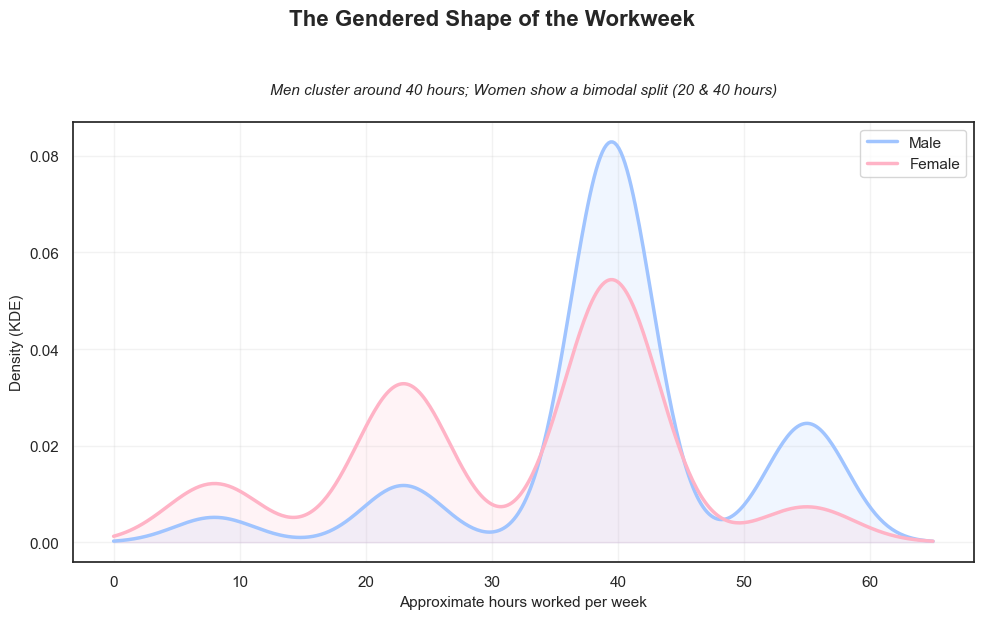


--- Plot 2: Occupation Distribution by Gender ---


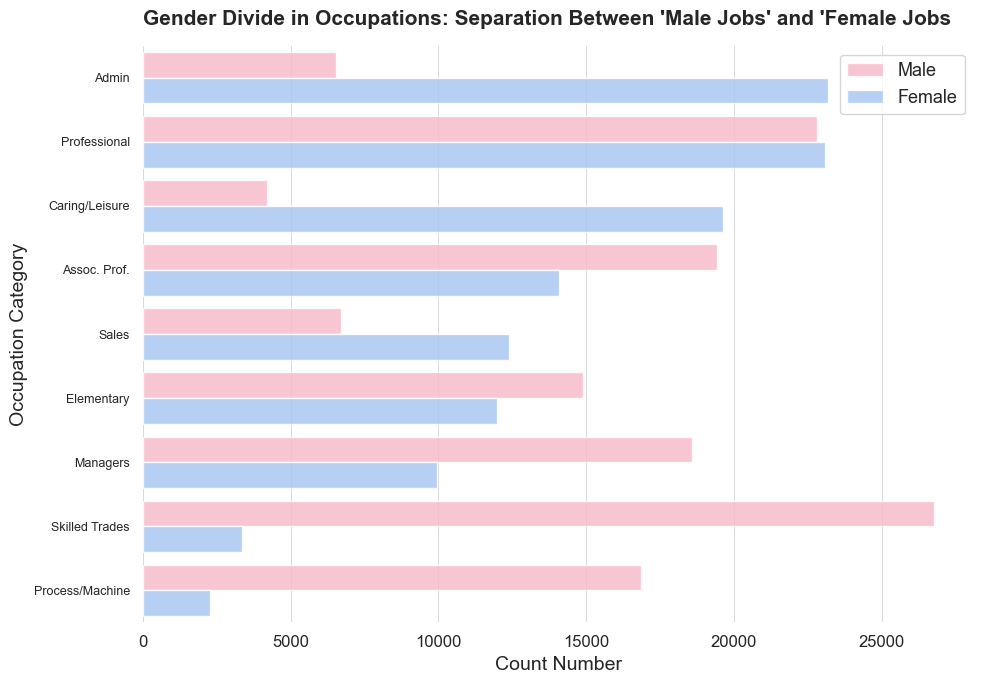


--- Plot 3: The Age-Health Connection ---


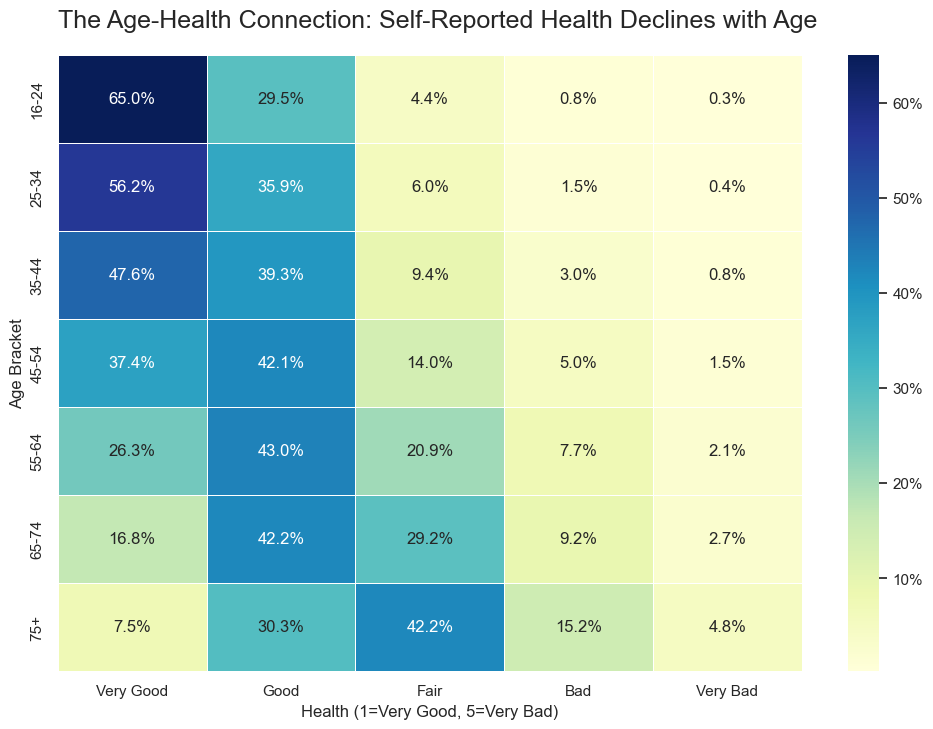


--- Plot 4: The UK's Workforce: A Treemap of Occupation Size ---



--- Plot 5: The Gender Divide: Occupation by Sex ---



--- Plot 6: Life's Path: How Economic Activity Varies by Marital Status ---


In [9]:
# --- Plot 1: The Gendered Shape of the Workweek (KDE) ---
print("\n--- Plot 1: The Gendered Shape of the Workweek ---")
male_hours_kde = df_working_pop.loc[df_working_pop["sex"]=="Male", "hours_numeric"].dropna()
female_hours_kde = df_working_pop.loc[df_working_pop["sex"]=="Female", "hours_numeric"].dropna()

kde_m = gaussian_kde(male_hours_kde, bw_method=0.3)
kde_f = gaussian_kde(female_hours_kde, bw_method=0.3)
x_grid = np.linspace(0, 65, 400)

plt.figure(figsize=(10, 6))
plt.plot(x_grid, kde_m(x_grid), color=MALE_COLOR, label="Male", linewidth=2.5)
plt.plot(x_grid, kde_f(x_grid), color=FEMALE_COLOR, label="Female", linewidth=2.5)
plt.fill_between(x_grid, kde_m(x_grid), alpha=0.15, color=MALE_COLOR)
plt.fill_between(x_grid, kde_f(x_grid), alpha=0.15, color=FEMALE_COLOR)
plt.xlabel("Approximate hours worked per week", fontsize=11)
plt.ylabel("Density (KDE)", fontsize=11)
plt.suptitle("The Gendered Shape of the Workweek", fontsize=16, fontweight='bold', y=1.03)
plt.title("Men cluster around 40 hours; Women show a bimodal split (20 & 40 hours)", fontsize=11, style='italic', pad=20)
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

# --- Plot 2: Occupation Distribution by Gender (Countplot) ---
print("\n--- Plot 2: Occupation Distribution by Gender ---")
df_female = df_working_pop[df_working_pop['sex'] == 'Female']
female_counts_by_occupation = df_female['occupation'].value_counts()
order_by_female_count = female_counts_by_occupation.index

plt.figure(figsize=(10, 7))
plt.grid(axis='x', color='lightgray', linewidth=0.6)
sns.countplot(
    data=df_working_pop,
    y="occupation",
    hue="sex",
    order=order_by_female_count,  
    palette=[FEMALE_COLOR, MALE_COLOR],
    alpha=0.85
)
plt.yticks(fontsize=9) 
plt.xticks(fontsize=12) 
plt.title("Gender Divide in Occupations: Separation Between 'Male Jobs' and 'Female Jobs", fontsize=15, fontweight='bold', pad=15, loc='left' )
plt.xlabel("Count Number", fontsize=14)
plt.ylabel("Occupation Category", fontsize=14)
plt.legend(title="", fontsize=13) 
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

# --- Plot 3: The Age-Health Connection ---
print("\n--- Plot 3: The Age-Health Connection ---")
df_health_age = df[
    (df['health'] != 'Not applicable') &
    (df['age'] != 'Not applicable') &
    (df['age'] != '0-15')
]
crosstab_norm = pd.crosstab(df_health_age['age'], df_health_age['health'], normalize='index')
health_order = ["Very Good", "Good", "Fair", "Bad", "Very Bad"]
crosstab_norm = crosstab_norm[health_order] 

fig_heat, ax_heat = plt.subplots(figsize=(12, 8))
sns.heatmap(
    crosstab_norm,
    annot=True,
    fmt='.1%',
    cmap='YlGnBu',
    linewidths=.5,
    ax=ax_heat,
    cbar_kws={'format': mtick.PercentFormatter(1.0)}
)
ax_heat.set_title('The Age-Health Connection: Self-Reported Health Declines with Age', fontsize=18, loc='left', pad=20)
ax_heat.set_xlabel('Health (1=Very Good, 5=Very Bad)', fontsize=12)
ax_heat.set_ylabel('Age Bracket', fontsize=12)
ax_heat.tick_params(axis='both', which='both', left=False, bottom=False)
plt.show()

# --- Plot 4: The UK's Workforce: A Treemap of Occupation Size ---
print("\n--- Plot 4: The UK's Workforce: A Treemap of Occupation Size ---")
df_treemap = df_working_pop.groupby('occupation')['person_id'].count().reset_index()

fig_tree = px.treemap(
    df_treemap,
    path=[px.Constant("All Occupations"), 'occupation'],
    values='person_id',
    title="The UK's Workforce: A Treemap of Occupation Size",
    color='occupation',
    color_discrete_map={
        "Managers": "#2ca02c", "Professional": "#1f77b4", "Assoc. Prof.": "#aec7e8",
        "Admin": "#ff7f0e", "Skilled Trades": "#ffbb78", "Caring/Leisure": "#d62728",
        "Sales": "#ff9896", "Process/Machine": "#9467bd", "Elementary": "#c5b0d5"
    },
    labels={'occupation': 'Occupation', 'person_id': 'Total People'},
    hover_data={'person_id': ':.0f'}
)
fig_tree.update_traces(textinfo="label+percent root", hovertemplate='<b>%{label}</b><br>Population: %{value:,.0f}<br>Share: %{percentRoot:.1%}')
fig_tree.update_layout(coloraxis_showscale=False, margin=dict(t=50, l=25, r=25, b=25))
fig_tree.show()

# --- Plot 5: The Gender Divide: Occupation by Sex ---
print("\n--- Plot 5: The Gender Divide: Occupation by Sex ---")
df_agg_gender = df_working_pop.groupby(['occupation', 'sex'])['person_id'].count().reset_index()
df_agg_gender['Percentage'] = df_agg_gender.groupby('occupation')['person_id'].transform(lambda x: x / x.sum())

fig_bar_gender = px.bar(
    df_agg_gender,
    x='occupation',
    y='Percentage',
    color='sex',
    title='The Gender Divide: Which Occupations are Dominated by Men vs. Women?',
    color_discrete_map={'Male': MALE_COLOR, 'Female': FEMALE_COLOR},
    labels={'occupation': 'Occupation', 'Percentage': 'Share of Workforce', 'sex': 'Sex'}
)
fig_bar_gender.update_traces(hovertemplate='<b>%{data.name}</b><br>Share: %{y:.1%}<extra></extra>')
fig_bar_gender.update_layout(
    yaxis_title='Share of Workforce',
    yaxis_tickformat='.0%',
    legend_title='Sex',
    plot_bgcolor='white',
    xaxis_title=None,
    xaxis={'categoryorder':'total descending'}
)
fig_bar_gender.show()

# --- Plot 6: Life's Path: Economic Activity by Marital Status ---
print("\n--- Plot 6: Life's Path: How Economic Activity Varies by Marital Status ---")
df_agg_marital_base = df[
    df['marital_status'].notna() & (df['marital_status'] != 'Not applicable') &
    df['economic_activity'].notna() & (df['economic_activity'] != 'Not applicable')
].copy()
df_agg_marital = df_agg_marital_base[
    df_agg_marital_base['economic_activity'].isin(['Employee', 'Self-employed', 'Looking after home or family', 'Retired', 'Unemployed'])
].groupby(['marital_status', 'economic_activity'])['person_id'].count().reset_index()
df_agg_marital['Percentage'] = df_agg_marital.groupby('marital_status')['person_id'].transform(lambda x: x / x.sum())

fig_marital = px.bar(
    df_agg_marital,
    x='marital_status',
    y='Percentage',
    color='economic_activity',
    title="Life's Path: How Economic Activity Varies by Marital Status",
    labels={'marital_status': 'Marital Status', 'Percentage': 'Share of Population', 'economic_activity': 'Economic Activity'},
    barmode='stack',
    color_discrete_map={
        'Employee': '#1f77b4', 'Self-employed': '#aec7e8', 'Unemployed': '#ff7f0e',
        'Looking after home or family': '#ffbb78', 'Retired': '#2ca02c'
    }
)
fig_marital.update_traces(hovertemplate='<b>%{data.name}</b><br>Share: %{y:.1%}<extra></extra>')
fig_marital.update_layout(
    yaxis_title='Share of Population',
    yaxis_tickformat='.0%',
    legend_title='Economic Activity',
    plot_bgcolor='white',
    xaxis_title=None
)
fig_marital.show()


--- Plot 7: The Regional Work-Hour Gender Gap ---


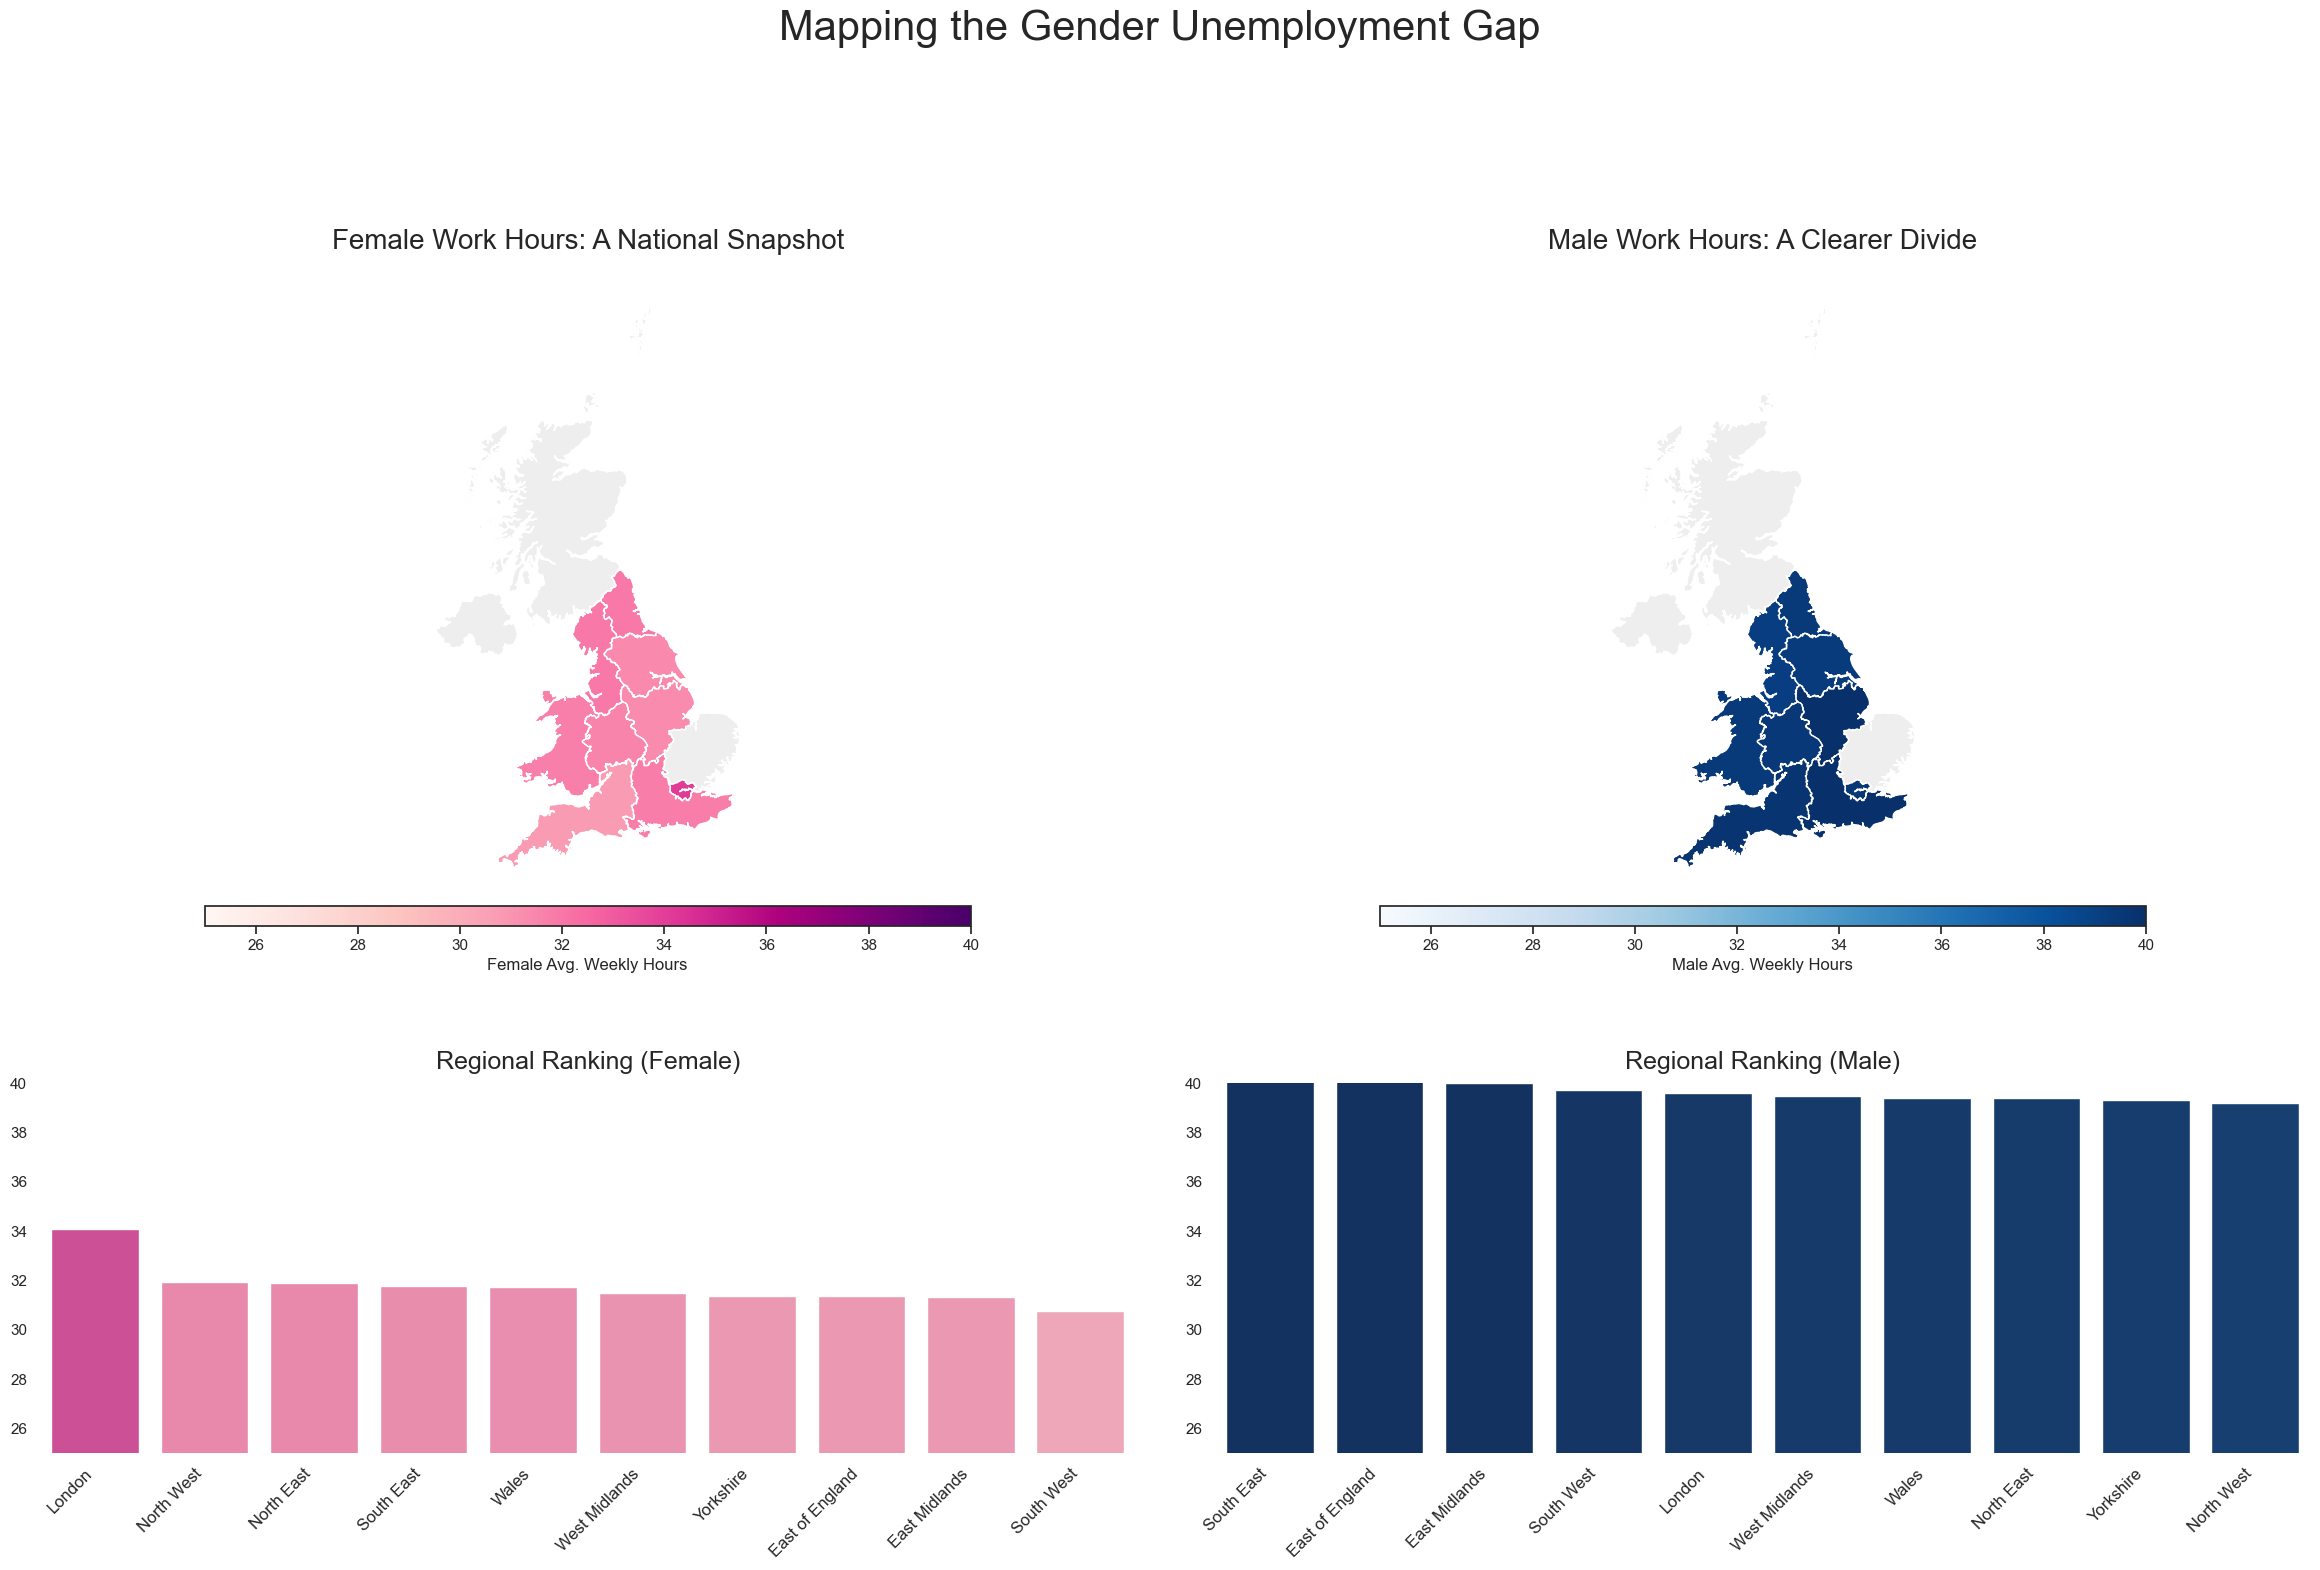

In [10]:
# --- Prep Data for Geospatial Plots ---
avg_hours_female = df_working_pop[df_working_pop['sex'] == 'Female'].groupby('region')['hours_numeric'].mean().reset_index(name='Avg_Hours_Worked')
avg_hours_female = avg_hours_female.sort_values('Avg_Hours_Worked', ascending=False)

avg_hours_male = df_working_pop[df_working_pop['sex'] == 'Male'].groupby('region')['hours_numeric'].mean().reset_index(name='Avg_Hours_Worked')
avg_hours_male = avg_hours_male.sort_values('Avg_Hours_Worked', ascending=False)

# --- Load Shapefile ---
shapefile_path = "data/NUTS1_Jan_2018_SGCB_in_the_UK.shp"
gdf = gpd.read_file(shapefile_path)
gdf['Region_Name'] = gdf['nuts118nm'].str.replace(' \(England\)', '', regex=True).str.title().str.strip()
gdf['Region_Name'] = gdf['Region_Name'].str.replace('Yorkshire And The Humber', 'Yorkshire')

# --- Merge Spatial and Aggregated Data ---
merged_female_hours = gdf.merge(avg_hours_female, left_on='Region_Name', right_on='region', how='left')
merged_male_hours = gdf.merge(avg_hours_male, left_on='Region_Name', right_on='region', how='left')

# --- Define Shared Scales for Comparison ---
shared_norm = plt.Normalize(vmin=25, vmax=40)
shared_ylim = (25, 40)
cmap_female = plt.get_cmap('RdPu')
cmap_male = plt.get_cmap('Blues')

female_bar_colors = [cmap_female(shared_norm(value)) for value in avg_hours_female['Avg_Hours_Worked']]
male_bar_colors = [cmap_male(shared_norm(value)) for value in avg_hours_male['Avg_Hours_Worked']]

# --- Plot the 2x2 Geospatial Dashboard ---
print("\n--- Plot 7: The Regional Work-Hour Gender Gap ---")
fig, axes = plt.subplots(2, 2, figsize=(24, 16), gridspec_kw={'height_ratios': [4, 2]})
no_data_color, map_edge_color = '#EEEEEE', '#FFFFFF'

legend_properties = {
    'orientation': 'horizontal',
    'shrink': 0.7,
    'aspect': 40,
    'pad': 0.01
}

# --- Female Map ---
ax_map1 = axes[0, 0]
gdf.plot(ax=ax_map1, color=no_data_color, edgecolor=map_edge_color)
merged_female_hours.dropna(subset=['Avg_Hours_Worked']).plot(
    column='Avg_Hours_Worked', cmap=cmap_female, ax=ax_map1, legend=True,
    legend_kwds={**legend_properties, 'label': 'Female Avg. Weekly Hours'},
    norm=shared_norm
)
ax_map1.set_title('Female Work Hours: A National Snapshot', fontsize=20, pad=10)
ax_map1.set_axis_off()
ax_map1.set_aspect('equal')

# --- Male Map ---
ax_map2 = axes[0, 1]
gdf.plot(ax=ax_map2, color=no_data_color, edgecolor=map_edge_color)
merged_male_hours.dropna(subset=['Avg_Hours_Worked']).plot(
    column='Avg_Hours_Worked', cmap=cmap_male, ax=ax_map2, legend=True,
    legend_kwds={**legend_properties, 'label': 'Male Avg. Weekly Hours'},
    norm=shared_norm
)
ax_map2.set_title('Male Work Hours: A Clearer Divide', fontsize=20, pad=10)
ax_map2.set_axis_off()
ax_map2.set_aspect('equal')

# --- Female Bar ---
ax_bar1 = axes[1, 0]
sns.barplot(data=avg_hours_female, x='region', y='Avg_Hours_Worked', ax=ax_bar1, palette=female_bar_colors)
ax_bar1.set_title('Regional Ranking (Female)', fontsize=18, pad=10)
ax_bar1.set_ylabel('')
ax_bar1.set_xlabel('')
ax_bar1.set_ylim(shared_ylim)
ax_bar1.tick_params(axis='both', which='both', left=False, bottom=False)
plt.setp(ax_bar1.get_xticklabels(), rotation=45, ha='right', fontsize=12)
sns.despine(ax=ax_bar1, left=True, bottom=True, right=True, top=True)

# --- Male Bar ---
ax_bar2 = axes[1, 1]
sns.barplot(data=avg_hours_male, x='region', y='Avg_Hours_Worked', ax=ax_bar2, palette=male_bar_colors)
ax_bar2.set_title('Regional Ranking (Male)', fontsize=18, pad=10)
ax_bar2.set_ylabel('')
ax_bar2.set_xlabel('')
ax_bar2.set_ylim(shared_ylim)
ax_bar2.tick_params(axis='both', which='both', left=False, bottom=False)
plt.setp(ax_bar2.get_xticklabels(), rotation=45, ha='right', fontsize=12)
sns.despine(ax=ax_bar2, left=True, bottom=True, right=True, top=True)

fig.suptitle('Mapping the Gender Unemployment Gap', fontsize=30, y=1.0)
plt.tight_layout(pad=3.0, h_pad=5.0, rect=[0, 0, 1, 0.95])
plt.show()


--- Model 1: Decomposing the Gender-Hours Gap ---

--- Plot 8: Waterfall Chart of Decomposition ---


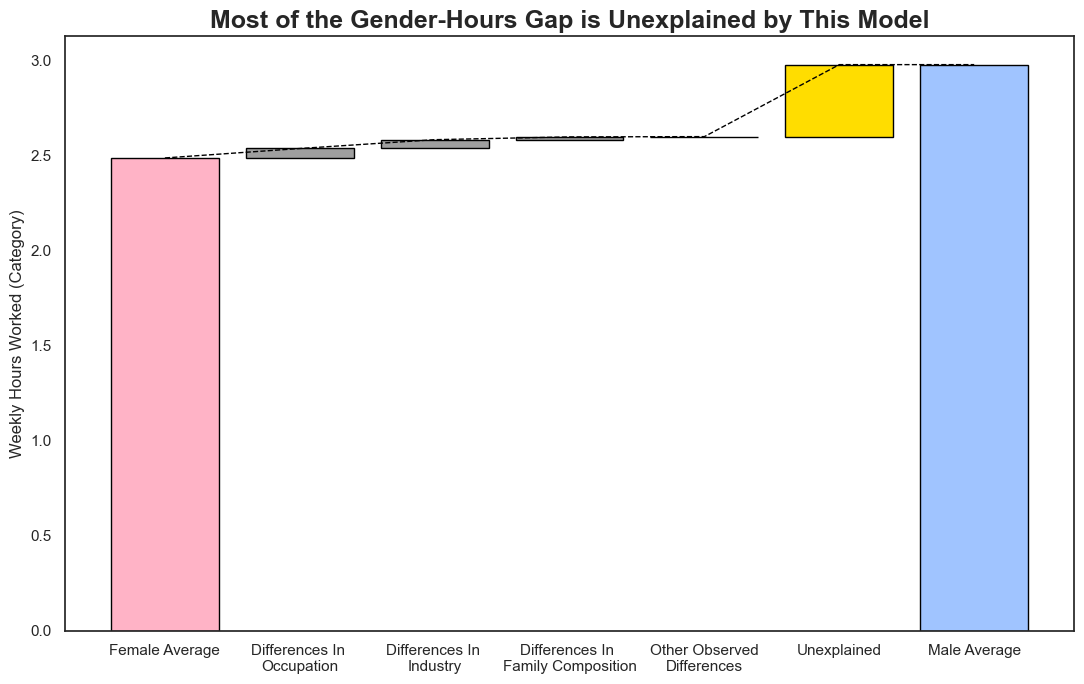

In [11]:
# --- Model 1: Oaxaca-Blinder Decomposition ---
print("\n--- Model 1: Decomposing the Gender-Hours Gap ---")

# --- 1. Filter Data for Model ---
df_model = df[
    (df['hours_worked_per_week'] != 0) &
    (df['age'] != '0 to 15') &
    (df['sex'].isin(['Male', 'Female']))
].copy()

# --- 2. Specify Model ---
spec = """hours_worked_per_week ~C(region) +C(family_composition) +C(age) +C(ethnic_group) +C(industry) +C(occupation) +C(country_of_birth) +C(health) +C(religion) +C(marital_status) +C(residence_type) +C(student)"""

# --- 3. Separate Data and run OLS for Women ---
df_men = df_model[df_model['sex']=='Male']
df_women = df_model[df_model['sex']=='Female']

y_w, X_w = patsy.dmatrices(spec, df_women, return_type="dataframe")
y_m, X_m = patsy.dmatrices(spec, df_men,   return_type="dataframe")
model_w = sm.OLS(y_w, X_w).fit()

# --- 4. Decompose the Gap ---
Xbar_m = X_m.mean()
Xbar_w = X_w.mean()
b_w    = model_w.params
term_contrib = (Xbar_m - Xbar_w) * b_w
term_contrib = term_contrib.drop(labels=["Intercept"], errors="ignore")
term_table = term_contrib.rename("explained_contribution").to_frame()

def parent_var(term: str) -> str:
    m = re.match(r"C\(([^)]+)\)\[T\..+\]", term)
    if m: return m.group(1)
    return term

var_map = term_table.index.to_series().apply(parent_var)
per_var = (term_table
           .groupby(var_map)
           ["explained_contribution"]
           .sum()
           .sort_values(ascending=False))
per_var_df = per_var.rename_axis("variable").reset_index(name="explained_contribution")

# --- 5. Prepare Data for Waterfall Chart ---
top = 3
per_var_top = per_var_df.head(top)
other_sum = per_var_df["explained_contribution"][top:].sum()
per_var_df_top = pd.concat([
    per_var_top,
    pd.DataFrame([{"variable": "other_variables", "explained_contribution": other_sum}])
], ignore_index=True)

explained = per_var_df['explained_contribution'].sum()
women_mean = df_model[df_model['sex'] == 'Female']['hours_worked_per_week'].mean()
men_mean = df_model[df_model['sex'] == 'Male']['hours_worked_per_week'].mean()
total = men_mean - women_mean
unexplained = total - explained

# --- 6. Plot Waterfall Chart ---
print("\n--- Plot 8: Waterfall Chart of Decomposition ---")
comp_labels = ['Differences In \nOccupation'] + ['Differences In \nIndustry'] + ['Differences In \nFamily Composition'] + ['Other Observed\nDifferences'] + ['Unexplained']
comp_steps  = per_var_df_top['explained_contribution'].tolist() + [unexplained]
labels = ['Female Average'] + comp_labels + ['Male Average']

cumulative = [women_mean]
for step in comp_steps:
    cumulative.append(cumulative[-1] + step)
y_for_line = cumulative + [men_mean]

plt.figure(figsize=(11, 7))
explained_color = "#9f9f9f"    
unexplained_color = "#FFDD00"

plt.bar(labels[0], women_mean, color=FEMALE_COLOR, edgecolor='black')

for i, (lab, step) in enumerate(zip(comp_labels, comp_steps), start=1):
    y0 = cumulative[i-1]
    color = unexplained_color if lab == 'Unexplained' else explained_color
    plt.bar(lab, step, bottom=y0, color=color, edgecolor='black')

plt.bar(labels[-1], men_mean, color=MALE_COLOR, edgecolor='black')
plt.plot(labels, y_for_line, linestyle='--', color='black', linewidth=1)

plt.ylabel("Weekly Hours Worked (Category)")
plt.title(label="Most of the Gender-Hours Gap is Unexplained by This Model",
          fontweight='bold', horizontalalignment='center', fontsize=18)
plt.tight_layout()
plt.show()


--- Model 2: Actual vs. Predicted Hours ---


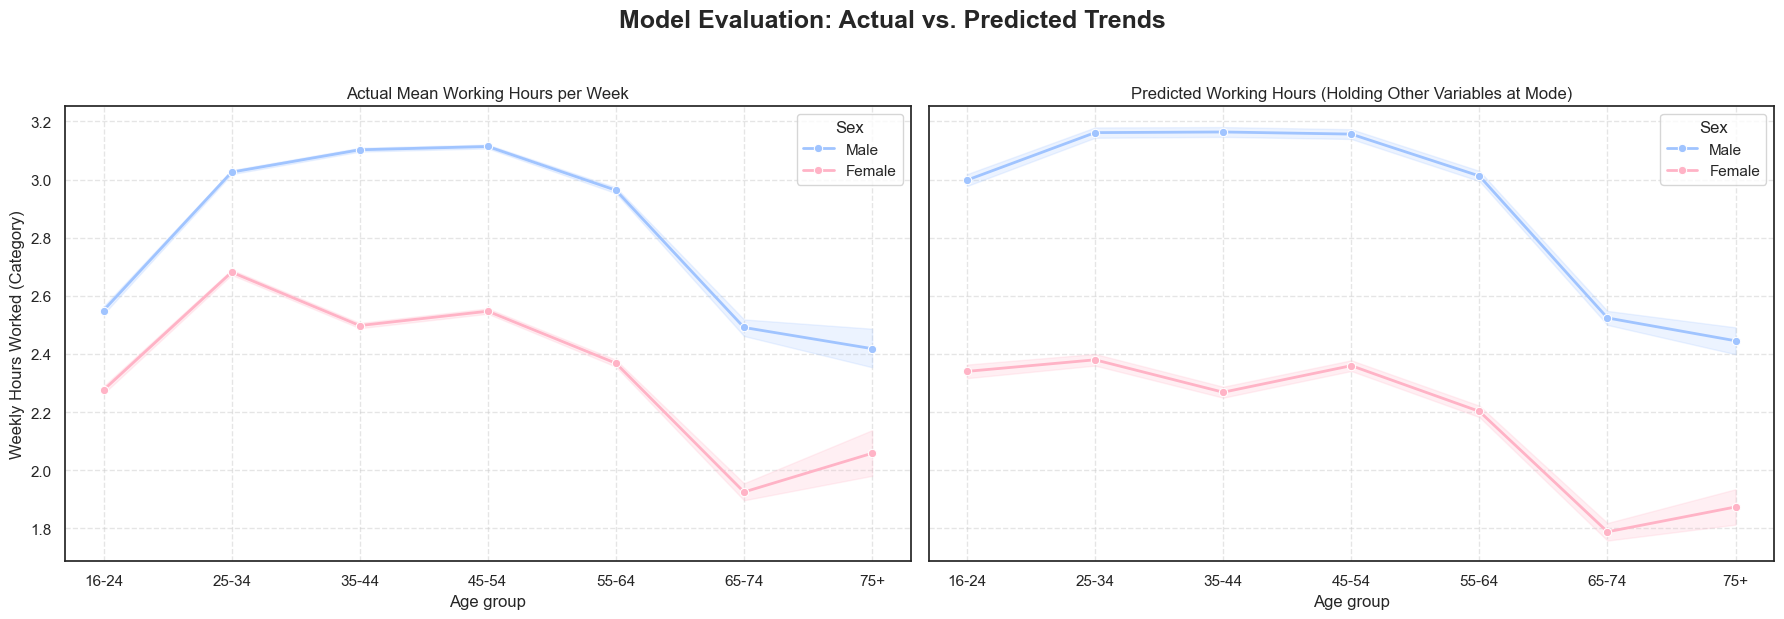

In [12]:
# --- Model 2: Actual vs. Predicted Plot ---
print("\n--- Model 2: Actual vs. Predicted Hours ---")

# --- 1. Fit Male Model ---
model_m = sm.OLS(y_m, X_m).fit()

# --- 2. Create Prediction Dataframes ---
if pd.api.types.is_categorical_dtype(df_model['age']):
    ages = list(df_model['age'].cat.categories)
else:
    ages = sorted(df_model['age'].dropna().unique().tolist())
    
df_model["age"] = pd.Categorical(df_model["age"], categories=ages, ordered=True)

predictors = [
    "region", "family_composition", "age", "ethnic_group", "industry", "occupation",
    "approximated_social_grade", "country_of_birth", "health", "religion",
    "economic_activity", "marital_status", "residence_type", "student"
]

def make_pred_df(df_group):
    modes = df_group[predictors].mode().iloc[0]
    rows = []
    for a in ages:
        row = {v: (a if v == "age" else modes[v]) for v in predictors}
        rows.append(row)
    return pd.DataFrame(rows)

pred_df_m = make_pred_df(df_men)
pred_df_w = make_pred_df(df_women)

# --- 3. Get Predictions ---
Xpred_m = build_design_matrices([X_m.design_info], pred_df_m)[0]
Xpred_w = build_design_matrices([X_w.design_info], pred_df_w)[0]

pred_m_res = model_m.get_prediction(Xpred_m).summary_frame(alpha=0.05)
pred_w_res = model_w.get_prediction(Xpred_w).summary_frame(alpha=0.05)

pred_m = pd.DataFrame({"age": ages, "yhat": pred_m_res["mean"], "ci_lo": pred_m_res["mean_ci_lower"], "ci_hi": pred_m_res["mean_ci_upper"], "sex": "Male"})
pred_w = pd.DataFrame({"age": ages, "yhat": pred_w_res["mean"], "ci_lo": pred_w_res["mean_ci_lower"], "ci_hi": pred_w_res["mean_ci_upper"], "sex": "Female"})
pred_all = pd.concat([pred_m, pred_w], ignore_index=True)
pred_all["age"] = pd.Categorical(pred_all["age"], categories=ages, ordered=True)

# --- 4. Plot Actual vs. Predicted ---
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
fig.suptitle("Model Evaluation: Actual vs. Predicted Trends", fontsize=18, fontweight="bold", y=1.03)

# Actual Plot
sns.lineplot(
    data=df_model, x="age", y="hours_worked_per_week", hue="sex",
    estimator="mean", ci=95, marker="o", linewidth=2,
    palette={"Male": MALE_COLOR, "Female": FEMALE_COLOR}, ax=axes[0]
)
axes[0].set_title("Actual Mean Working Hours per Week")
axes[0].set_xlabel("Age group")
axes[0].set_ylabel("Weekly Hours Worked (Category)")
axes[0].grid(True, linestyle="--", alpha=0.5)
axes[0].legend(title="Sex")

# Predicted Plot
sns.lineplot(
    data=pred_all, x="age", y="yhat", hue="sex",
    palette={"Male": MALE_COLOR, "Female": FEMALE_COLOR}, marker="o", linewidth=2,
    ax=axes[1]
)
for sex, color in [("Male", MALE_COLOR), ("Female", FEMALE_COLOR)]:
    sub = pred_all[pred_all["sex"] == sex]
    axes[1].fill_between(sub["age"], sub["ci_lo"], sub["ci_hi"], alpha=0.2, color=color)
axes[1].set_title("Predicted Working Hours (Holding Other Variables at Mode)")
axes[1].set_xlabel("Age group")
axes[1].set_ylabel("Weekly Hours Worked (Category)")
axes[1].grid(True, linestyle="--", alpha=0.5)
axes[1].legend(title="Sex")

plt.tight_layout()
plt.show()

### Conclusion: Analysis of Findings

Our analysis of the 2011 Census data reveals several key insights into the demographic and economic landscape of England and Wales.

#### The "Maternity Penalty" in Hours Worked

The trend of hours worked across the life cycle is consistent between men and women, with one significant exception: **women aged 35-44**.

This group shows a distinct dip in average hours worked. This divergence indicates the powerful effect of life events such as marriage or childbirth (the average age for a first child in the UK is around 30). This initial dip leads to a widening gap in hours worked in later age brackets.

This evidence strongly corresponds with the established economic concept of the **"Maternity Penalty,"** where women's career and earning trajectories show a marked slowdown after childbirth, often linked to taking on the majority of childcare responsibilities.

#### Modeling the Gender-Hours Gap

**Modeling Process**
To investigate this gap, we used an **Oaxaca-Blinder decomposition**. This method involves estimating the hours worked for men and women separately, which allows us to break down the observed gap in mean hours worked into two parts:
1.  **Explained:** Differences in observable characteristics (e.g., occupation, industry).
2.  **Unexplained:** The residual gap, which persists even when comparing men and women with similar characteristics.

**Model Evaluation**
* **R-squared:** The R-squared values for our models were low (0.23-0.24). This is expected with such a large dataset (over 500,000 rows). The high degree of real-world heterogeneity (individual differences) is impossible for any model to capture fully.
* **Fit-for-Purpose:** While we could have used non-linear models to improve predictive accuracy, our goal was *explanation* (interpreting the *why*). The linear model, while not a perfect predictor, tracks the real-world age trends reasonably well (as seen in our "Actual vs. Predicted" plot) and is therefore fit-for-purpose.



**Waterfall Chart Analysis**
The decomposition model reveals that the top three factors contributing to the *explained* portion of the gap are:
1.  Differences in Occupation
2.  Differences in Industry
3.  Differences in Family Composition

This aligns well with existing economic literature. However, the largest single component of the gap in our model remains **unexplained**.

#### Is the Unexplained Gap Evidence of Discrimination?

Discrimination is, by definition, unobserved. The residual "unexplained" gap would only equal discrimination if we could assume our model was fully specified and included every possible factor that determines hours worked.

This is a highly unrealistic assumption.
* **Missing Variables:** Our model lacks crucial data, most notably **education level**, which is a primary predictor of career outcomes.
* **Unobservable Factors:** The model cannot account for personal choices or unobservable factors like individual motivation.

As a result, we cannot state that the entire residual gap is due to discrimination. However, its large size strongly indicates that discrimination is **likely a significant component** within that unexplained portion.